# Classical/Frequentist Statistical Inference: I

*Davide Gerosa (Milano-Bicocca)*

##### Reading:

- [Ivezic textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 4. 
- [Cowan, Statistical Data Analysis](https://www.amazon.com/Statistical-Analysis-Oxford-Science-Publications/dp/0198501552) (I personally find the frequenstist chapters in this book very clear)


This course is based on previous work by many people. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/README.md) for credits.


---

## Statistical Inference

Statistical *inference* is about drawing conclusions from data, specifically determining the properties of a population by data sampling.

Three examples of inference are:
1. What is the best estimate for a model parameter?
2. How confident we are about our result?
3. Are the data consistent with a particular model/hypothesis?

### Some Terminology

* We typically study the properties of some ***population*** by measuring ***samples*** from that population. The population doesn't have to refer to different objects. E.g., we may be (re)measuring the position of an object at rest; the population is the distribution of (an infinite number of) measurements smeared by the uncertainty, and the sample are the measurement we've actually taken.


* A ***statistic*** is any function of the sample. For example, the sample mean is a statistic. But also, "the value of the first measurement" is also a statistic.

* To conclude something about the population from the sample, we develop ***estimators***. An estimator is a statistic, a rule for calculating an estimate of a given quantity based on observed data.


* There are ***point*** and ***interval estimators***. The point estimators yield single-valued results (example: the position of an object), while with an interval estimator, the result would be a range of plausible values (example: confidence interval for the position of an object).


* Measurements have **uncertainties** (not errors) and we need to account for these (sometimes they are unknown).

* Data are not variables but fixed values

### Frequentist vs. Bayesian Inference

There are two major statistical paradigms that address the statistical inference questions: 
- the **classical**, or **frequentist** paradigm,
- the **Bayesian** paradigm.

While most of statistics and machine learning is based on the classical paradigm, Bayesian techniques are being embraced by the statistical and scientific communities at an ever-increasing pace...especially in astrophysics.

#### Key differences
- **Definition of probabilities**:
    - In ***frequentist inference***, probabilities describe the ***relative frequency of events*** over repeated experimental trials. 
    - In ***Bayesian inferenece***, probabilities instead quantify our ***subjective belief about experimental outcomes, model parameters, or even models themselves***. 
    
    
- **Quantifying uncertainty**:
    - In ***frequentist inference*** we have ***confidence levels*** that describe the distribution of the measured parameter from the data around the true value.
    - In ***Bayesian inference*** we have ***credible regions*** derived from posterior probabilitiy distributions (we'll meet these later). These encode our "***belief spread***" in model parameters. 

### Example

The following article provides a nice example that is visualized below (without the detailed math): [Efron 1978 "Controversies in the Foundations of Statistics"](http://www.jstor.org/stable/2321163?seq=1#page_scan_tab_contents).

The IQ of the population has mean of 100 and standard deviation 15. Alice takes a test which returns an IQ of 160. Given these pieces of information, what is the IQ of Alice?

Note Alice takes the test only once. A frequentists would say that 160 is best possibile estimator for Alice's IQ true value. A Bayesian instead would instead conclude Alice had lucky day and her true IQ is lower than 160 because it's very unlikely to get 160 among people that usually get 100. 

Let's see the result before the maths:

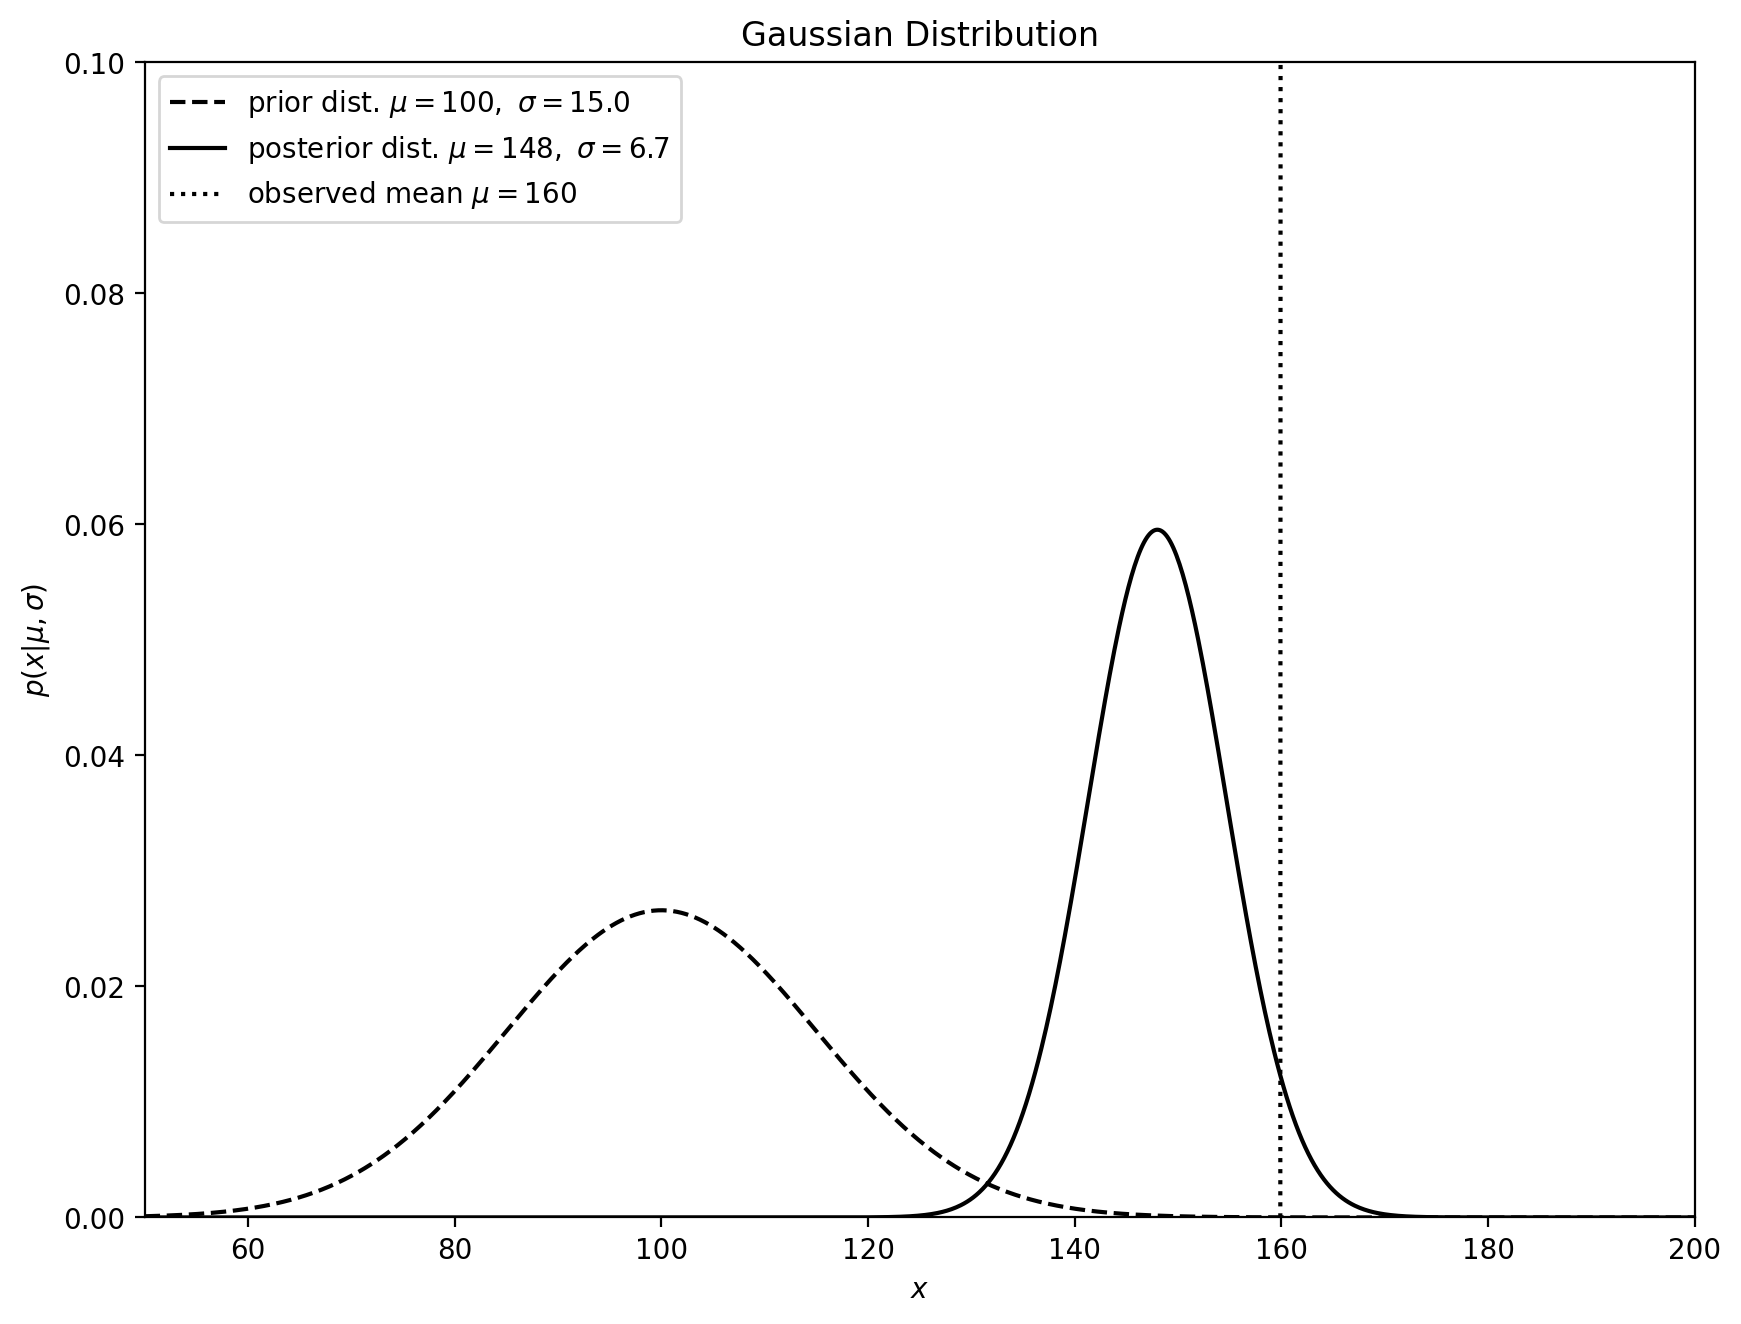

In [8]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=10, usetex=True)

#------------------------------------------------------------
# Define the distributions to be plotted
sigma_values = [15, 6.7, 1] #complete with the prior width of IQ distribution
linestyles = ['--', '-', ':']
mu_values = [100, 148, 160] #complete with the prior mean of IQ distribution
labeltext = ['prior dist.', 
             'posterior dist.', 
             'observed mean']
xplot = np.linspace(50, 200, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))

for sigma, ls, mu, lab in zip(sigma_values, 
                              linestyles, 
                              mu_values, 
                              labeltext):
    
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    if sigma > 1:
        plt.plot(xplot, dist.pdf(xplot), 
                 ls=ls, c='black',
                 label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9, 160.1], [0, 0.8], 
                 ls=ls, color='k', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()

The end result (skipping over the detailed math) is that Alice's is not 160, but rather 148! More specifically, my Bayesian measurement is that $p(141.3\le \mu \le 154.7 \, | \, \overline{x}=160) = 0.683$ (i.e. there's a probability of 68% that Alice's IQ is between 141.3 and 154.7). This estimate incorporates not only the test I made to that person, but also the prior information of how the IQ distribution is calibrated. We already saw (remember the Monty Hall problem?) the huge influence that priors can have and why considering priors is very reasonable (in Monty Hall, you're more likely to win!)

This all seems totally fine; where's the controvery with Bayesian methods? If you go through with this idea,  everything (but data!) needs to be promoted to a random variable, incluing a theory (what does it mean that the Standard Model of Particle Physics is a random variable?) or a constant of nature (what does it mean that the speed of light is a random variable?). We'll return to this in a few lectures.

## Maximum Likelihood Estimation (MLE) <a class="anchor" id="two"></a>

Today we're frequentists. Let's talk about maximum likelihood estimation ($\S 4.2$ in the textbook)

### Maximum Likelihood Approach

Maximum likelihood estimation follows this blueprint:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, the data are a measurement of some quantity with Gaussian random uncertainties (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.


2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M(\theta))$. This search yields the MLE *point estimates*, $\boldsymbol{\theta^0}$.


3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta^0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation (we'll come to these later).


4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

### Example: Measuring the Position of a Quasar

Let's assume we wish to estimate the position $x$ of a quasar from a series of individual astrometric measurements.

1. We adopt a model where the observed quasar does not move, and has individual measurement uncertainties 
2. We derive the expression for the likelihood of there being a quasar at position $x_0$ that gives rise to our individual measurements. We find the value of $\hat x_0$ for which our observations are maximally likely.
3. We determine the uncertainties (confidence intervals) on our measurement.
4. We test whether what we've observed is consistent with our adopted model. For example, is it possible that the quasar was really a misidentified star with measurable proper motion?

Note: in the text to come, I will use $\mu$ instead of $x_0$ to denote the true position of the quasar. This is to avoid potential confusion with the first (or zeroth) measurement of $x$.

Keep this workflow in mind...

### The Likelihood Function


If we know the distribution from which our data were drawn (or make a hypothesis about it), then we can compute the **probability** of our data being generated.

Another way of saying the same thing: **the likelihood is your model for process that generates the data.**

Therefore, the likelihood is a function of the data given the parameters (not the other way round).

For example, if our data are generated by a Gaussian process with mean $\mu$ and standard deviation $\sigma$, then the probability density of a certain value $x$ is

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

If we want to know the total probability of our ***entire*** data set (as opposed to one measurement) then we must compute the ***product*** of all the individual probabilities:

$$L \equiv p(\{x_i\}|M(\theta)) = \prod_{i=1}^N p(x_i|M(\theta)),$$

where $M$ is the *model* and $\theta$ refers collectively to the $k$ parameters of the model, which can generally be multi-dimensional. In words...

> $L(\{x_i\})\equiv$ the probability of the data given the model parameters. 

If we consider $L$ as a function of the model parameters, we refer to it as

> $L(\theta)\equiv$ likelihood of the model parameters, given the observed data. 

Careful what's been done here: **we're thinking about the probability of the data as a function of the model parameters.** This is the crucial point behind MLE (and inference in general).

Note:
- [Jeynes](https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712) is quite strict on how refer to the likelihood of model parameters versus the probability of the data.
- while the components of $L$ may be normalized pdfs, their product is not.
- the product can be very small, so we often take the log of $L$. 
- we're assuming the individual measurements are independent of each other.

We can write $L$ out as

$$L = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$

and simplify to

$$L = \left( \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right),$$

where we have written the product of the exponentials as the exponential of the sum of the arguments, which will make things easier to deal with later.

If you have done $\chi^2$ analysis (e.g., doing a linear least-squares fit), then you might notice that the argument of the exponential is just 

$$\exp \left(-\frac{\chi^2}{2}\right).$$

That is, for our gaussian distribution

$$\chi^2 = \sum_{i=1}^N \left ( \frac{x_i-\mu}{\sigma}\right)^2.$$

So for Gaussians **maximizing the likelihood or log-likelihood is the same as minimizing $\chi^2$**.  In both cases we are finding the most likely values of our model parameters (here $\mu$ and $\sigma$).  


### Properties of ML Estimators

Assuming the data truly are drawn from the model, ML estimators have the following useful properties:

* **They are consistent estimators**. They converge to the true parameter value as $N\to\infty$.


* **They are asymptotically normal estimators**. As $N\to\infty$ the distribution of the parameter estimate approaches a normal distribution, centered at the MLE, with a certain spread.


* **They asymptotically achieve the theoretical minimum possible variance, called the Cramér–Rao bound**. They achieve the best possible uncertainty given the data at hand; no other estimator can do better in terms of efficiently using each data point to reduce the total error of the estimate (see eq. 3.33 in the textbook).

This is why you've been doing $\chi^2$ all the time. You want a MLE, which is the same as minimizing $\chi^2$ ***if*** data are Gaussian. This is reasonable because of the Central Limit Theorem, but not always true! 

### The key idea behind Maximum Likelihood Estimation

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters).

Then Maximum Likelihood Estimation method tells us to think of the likelihood as a ***function of the unknown model parameters***, and to ***find the parameters that maximize the value of $L$***. Those will be our *Maximum Likelihood Estimators* for for the true values of the model.

## MLE applied to a homoscedastic Gaussian <a class="anchor" id="three"></a>

Let's take a look at our astrometry example, using a model where all the measurements have the same uncertainty, drawn from a normal distribution, $N(0, \sigma)$.

As mentioned back in our early lectures, uncertainties being the same is known as having **homoscedastic** uncertainties which just means "uniform uncertainties".  Later we will consider the case where the measurements can have different uncertainties ($\sigma_i$) which is called **heteroscedastic**.

We have an experiment with the set of measured positions $D=\{x_i\}$ in 1D with Gaussian uncertainties, and therefore:

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Note that that is $p(\{x_i\})$ not $p(x_i)$, that is the probability of the full data set, not just one measurement. If $\sigma$ is both constant and *known*, then this is a one parameter model with $k=1$ and $\theta_1=\mu$. 

We're assuming we know the spread of the measurments $\sigma$ here (say it depends on the properties of the telescope), but of course that's not always the case.

As we found above, likelihoods can be really small, so let's define the **log-likelihood function** as ${\ln L} = \ln[L(\theta)]$.  The maximum of this function happens at the same place as the maximum of $L$.  Note that any constants in $L$ have the same effect for all model parameters, so constant terms can be ignored.  

In this case we then have 

$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Take a second and make sure that you understand how we got there.  It might help to remember that above, we wrote

$$L = \prod_{i=1}^N \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right).$$

We then determine the maximum in the same way that we always do.  It is the parameter set for which the derivative of ${\rm lnL}$ is zero:

$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} \equiv 0.$$

That gives $$ \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma^2} = 0.$$

Note: 
- We should also check that the $2^{\rm nd}$ derivative is negative, to ensure this is the *maximum* of $L$.
- Bimodality? We need something more.
- Any constants in $\ln L$ disappear when differentiated, so constant terms can typically be ignored. This will change if we're trying to select between different models, rather than just parameter estimation within a single model as we're doing here.

Since $\sigma = {\rm constant}$ (not always, but here at least), that says 

$$\sum_{i=1}^N x_i = \sum_{i=1}^N \hat \mu = N \hat \mu.$$

Thus we find that

$$\hat \mu = \frac{1}{N}\sum_{i=1}^N x_i,$$

***which is just the sample arithmetic mean of all the measurements!*** Thus **the sample mean is a ML estimator**. We got there in a roundabout way, but still pretty easy.

So at the end of the day, if you know the $\sigma$ of your quasar measuurements (perhaps because it comes from the property of the telescope), just compute a mean.

## Quantifying estimate uncertainty <a class="anchor" id="four"></a>

Our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the shape and distribution of the likelihood function, but we'd like to capture that with a few numbers.

Note: $\sigma$ is *not* the uncertanty on $\mu$!

The ***asymptotic normality of MLE*** is invoked to approximate the likelihood function as a Gaussian (or the $\ln L$ as a parabola), i.e. we take a Taylor expansion around the MLE, keep terms up $2^\mathrm{nd}$ order, then *define* the uncertainty on our model parameters as:

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

where

$$ F_{jk} = - \frac{d^2 \ln L}{d\theta_j d\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

The matrix $F$ is known as the **Fisher information matrix**.  The elements $\sigma^2_{jk}$ are known as the ***covariance matrix***.

Has anybody heard about the Fisher matrix before? In what context?
*Digression*: a nice write up on the ["Use and Abuse of the Fisher Information Matrix" by Vallisneri (2007)](https://arxiv.org/abs/gr-qc/0703086)


The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement. Off diagonal elements, $\sigma_{ij}$, arise from any correlation between the parameters in the model.

In our example of a homoscedastic Gaussian, the uncertainly on the mean is 

$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find

$$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$

since, again, $\sigma = {\rm constant}$.  

Then 

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you should be familiar with. 

The $(\hat \mu - \sigma_\mu, \hat \mu + \sigma_\mu)$ range gives us a **confidence interval**.

In frequentist interptetation, if we repeated the same measurement a hundred times, we'd find for 68 experiments the true value was within their computed confidence intervals ($1 \sigma$ errors).

## MLE applied to a Heteroscedastic Gaussian <a class="anchor" id="five"></a>

Now let's look a case where the uncertainties are heteroscedastic.  For example if we are measuring the position of a quasar $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement, $\sigma_i$ is known (say the setups in your telescope changed: you know what they are, but they're different every night).  Since $\sigma$ is not a constant, then following the above, we have

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} = \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\hat \mu}{\sigma_i^2},$$

yields a MLE solution of 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$




## Working with non-Gaussian Likelihoods <a class="anchor" id="six"></a>

As an example of MLE with non-Gaussian probability density we can use the same formalism above for a Poisson distribution. In this case we write the probability disrtibution as

$$p(x_i|\mu) = \frac{e^{-\mu}\mu^{x_i}}{x_i!}$$

with $\mu$ the average number of events, $N$ is the number of observed events, and $\{x_i\}$ are the measured data.

As we saw before, this distribution is particularly useful for characterizing the number of soldiers in the Prussian army killed accidentally by horse kicks. That is indeed a typical task in modern astrophysics research.

We can then write the likelihood as

$$L \equiv p(\{x_i\}|\mu) = \prod_{i=1}^{N} \frac{e^{-\mu}\mu^{x_i}}{x_i!}$$

and the $\ln L$ as

$$\ln L = \sum_{i=1}^{N} \ln \bigg( \frac{e^{-\mu}\mu^{x_i}}{x_i!} \bigg)$$

$$= \sum_{i=1}^{N} -\mu + x_i \; \ln(\mu) - \ln({x_i!})$$

Let's plot the likelihood

12.1010101010101


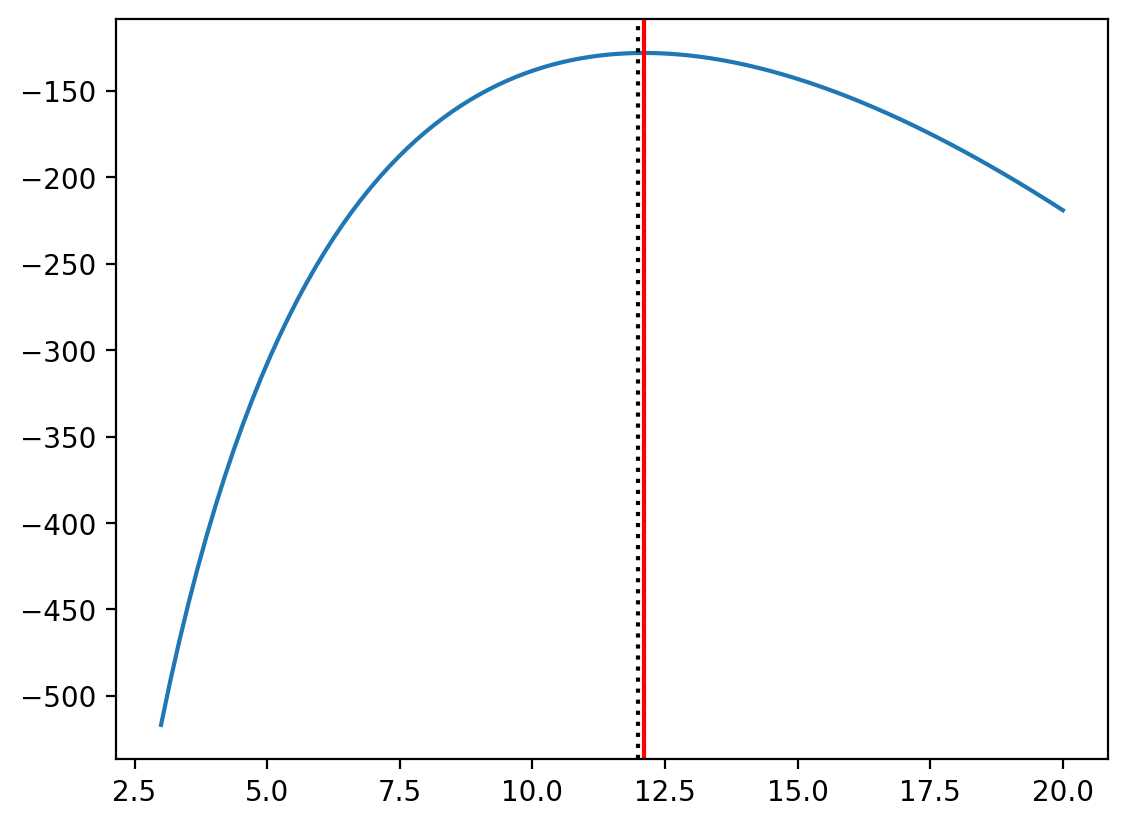

In [11]:
from scipy.stats import poisson

poisson_data = poisson.rvs(12, size=50)

# Scan across 1000 possible mu values from 3 to 20.
mu_proposed = np.linspace(3,20,100)

# compute the lnL for each possible mu.
lnL_scan = []
for mu in mu_proposed:
    lnL_temp = poisson.logpmf(poisson_data, mu=mu) # gives you the log prob. density; useful!
    lnL_temp = np.sum(lnL_temp) # sum over the log pmf of all data points
    lnL_scan.append( lnL_temp )
    
# convert to numpy array
lnL_scan = np.array(lnL_scan)

# mu_proposed that maximizes the lnL.
plt.plot(mu_proposed,lnL_scan)

findmax = mu_proposed[np.argmax(lnL_scan)]
print(findmax)
plt.axvline(findmax,c='red')

plt.axvline(12,c='black',ls='dotted')

### Maximizing the $\ln L$ 

For the Poisson distribution we can solve for the maximum liklehood analytically

$$\frac{\partial \; L(\mu)}{\partial \; \mu} = \frac{\partial \; }{\partial \; \mu} \bigg( \sum_{i=1}^{N} -\mu + x_i \; \ln(\mu)\bigg)$$

$$0 = \sum_{i=1}^{N} \bigg( -1 + \frac{x_i}{\mu} \bigg)$$
$$\hat\mu = \frac{1}{N} \sum_{i=1}^{N} x_i $$

What do you know!? The same as for a homoescedastic Gaussian! 

***For many likelihoods we cannot solve for the maximum analytically, and we have to resort to numerical solutions.*** We'll treat these in detail later using MCMC and robust statistics that account for outliers.

In [12]:
np.mean(poisson_data)

12.1

## Time to get you hands dirty!  Position of a quasar

You measure the position of a quasar $N$ times with the *same* telescope i.e. errors are homoscedastic. Let's say the underlying process is Gaussian, the true position is $\mu = 1$ (in suitable units), and the erorrs are $\sigma=0.2$

### Part 1

- Generate fake measurements. Treat each of these observations as an estimate of the true distribution. So we'll center a Gaussian (with the known $\sigma$) at each point. This is the probability of each data point, $p(x_i|\mu,\sigma)$.
- Plot each of the individual likelihoods separately.  Also plot their product (i.e. the likelihood of the dataset $\{x_i\}$). Make sure the x grid has enough points.
- Just read off the maximum likelihood solution (e.g. using `np.argsort`) 
- Compare it with the MLE estimator derived above

### Part 2

Check the Fisher matrix error estimate makes sense
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide through by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.
- Compare with the Fisher matrix error derived above
- Plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution. (The normalization won't be captured, you can rescale it as you like to check it agrees) 

### Part 3

Let's make our model more realistic. Our $N$ measurements were taken in different nights, where the sky behaved differently (i.e. errors are heteoscedastic). Let's assume that each measurment has a $\sigma_i$ that is normally distributed with mean $0.2$ and standard deviation $0.05$

- Generalize your code from above to this case

[My solution](https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/solutions/S06_mockquasarposition.ipynb) 